In [56]:
%matplotlib inline

import datetime
import json
import matplotlib.pyplot as plt
import numpy as np
import pickle
from sklearn import linear_model
from collections import defaultdict
from collections import OrderedDict

In [8]:
f = open('prediction/all_boxscores_2000_2017.json')
boxscore_data = json.load(f)

In [9]:
boxscore_data_ordered_by_key = OrderedDict(sorted(boxscore_data.items()))

In [10]:
# build running averages of stats in a season for a team
# team-ID -> season -> team's game ID -> stat_type -> average (inclusive of current game)
team_boxscore_rolling_averages = defaultdict(lambda: defaultdict(lambda: defaultdict(dict)))

boxscore_categories = ['boxscoretraditionalv2', 'boxscoreadvancedv2', 'boxscoremiscv2', 'boxscorescoringv2',
                       'boxscoreusagev2', 'boxscorefourfactorsv2', 'boxscoreplayertrackv2', 'hustlestatsboxscore',
                       'boxscoresummaryv2']

def prune_team_stats(team_stats):
  pruned_team_stats = []
  stat_name_index_tuples = [
    ('FGM', 6),
    ('FGA', 7),
    ('FG_PCT', 8),
    ('FG3M', 9),
    ('FG3A', 10),
    ('FG3_PCT', 11),
    ('FTM', 12),
    ('FTA', 13),
    ('FT_PCT', 14),
    ('OREB', 15),
    ('DREB', 16),
    ('REB', 17),
    ('AST', 18),
    ('STL', 19),
    ('BLK', 20),
    ('TO', 21),
    ('PF', 22),
    ('PTS', 23),
    ('PLUS_MINUS', 24)
  ]
  
  for stat_name_index_tuple in stat_name_index_tuples:
    pruned_team_stats.append(team_stats[stat_name_index_tuple[1]])
  
  return np.asarray(pruned_team_stats)

def prune_starter_bench_stats(team_starter_bench_stats):
  pruned_team_starter_bench_stats = []
  stat_name_index_tuples = [
    ('FGM', 7),
    ('FGA', 8),
    ('FG_PCT', 9),
    ('FG3M', 10),
    ('FG3A', 11),
    ('FG3_PCT', 12),
    ('FTM', 13),
    ('FTA', 14),
    ('FT_PCT', 15),
    ('OREB', 16),
    ('DREB', 17),
    ('REB', 18),
    ('AST', 19),
    ('STL', 20),
    ('BLK', 21),
    ('TO', 22),
    ('PF', 23),
    ('PTS', 24),
  ]
  
  for stat_name_index_tuple in stat_name_index_tuples:
    pruned_team_starter_bench_stats.append(team_starter_bench_stats[stat_name_index_tuple[1]])
  
  return np.asarray(pruned_team_starter_bench_stats)

# maintains state about how many games were played by a team in a season, reset every season
# TEAM_ID -> num games played
team_games_played_dict = defaultdict(lambda: 1)
prev_game_id_dict = defaultdict(str)

# team_id -> game_id -> previous game ID
game_sequence_dict = defaultdict(lambda: defaultdict(str))

game_ids_by_season = defaultdict(list)

home_away_team_indices_by_game_id = {}

prev_game_num = None
prev_game_id = None
for json_file_name, data in boxscore_data_ordered_by_key.iteritems():
  game_id = json_file_name.split('.')[0]
  game_num = game_id[-4:]
  season = game_id[3:5]
  if game_num == '0001':
    team_games_played_dict = defaultdict(lambda: 1)
    prev_game_id_dict = defaultdict(str)
  for boxscore_category in boxscore_categories:
    category_data = boxscore_data[json_file_name][boxscore_category]
    if boxscore_category == 'boxscoretraditionalv2':
      if 'resultSets' in category_data:
        data = category_data['resultSets']
        if len(data[1]['rowSet']) == 0:
          continue
        boxscore_summary_data = boxscore_data[json_file_name]['boxscoresummaryv2']['resultSets'][0]['rowSet'][0]
        game_ids_by_season[season].append(game_id)
        home_team_id = boxscore_summary_data[6]
        away_team_id = boxscore_summary_data[7]
        away_team_idx = None
        home_team_idx = None
        if data[1]['rowSet'][0][1] == home_team_id:
          away_team_idx = 1
          home_team_idx = 0
        else:
          away_team_idx = 0
          home_team_idx = 1
        home_away_team_indices_by_game_id[game_id] = (away_team_idx, home_team_idx)
        team_stats_away = data[1]['rowSet'][away_team_idx]
        team_stats_home = data[1]['rowSet'][home_team_idx]
        pruned_team_stats_away_features = prune_team_stats(team_stats_away)
        pruned_team_stats_home_features = prune_team_stats(team_stats_home)
        team_starter_stats_away = data[2]['rowSet'][0]
        team_bench_stats_away = data[2]['rowSet'][1]
        team_starter_stats_home = data[2]['rowSet'][2]
        team_bench_stats_home = data[2]['rowSet'][3]
        pruned_starter_stats_away = prune_starter_bench_stats(team_starter_stats_away)
        pruned_bench_stats_away = prune_starter_bench_stats(team_bench_stats_away)
        pruned_starter_stats_home = prune_starter_bench_stats(team_starter_stats_home)
        pruned_bench_stats_home = prune_starter_bench_stats(team_bench_stats_away)
        
        if team_games_played_dict[away_team_id] == 1:
          team_boxscore_rolling_averages[away_team_id][season][game_id]['team_stats'] = pruned_team_stats_away_features
        else:
          prev_game_num = team_games_played_dict[away_team_id] - 1
          curr_game_num = team_games_played_dict[away_team_id]
          prev_game_id = prev_game_id_dict[away_team_id]
          game_sequence_dict[away_team_id][game_id] = prev_game_id
          prev_away_team_stats = team_boxscore_rolling_averages[away_team_id][season][prev_game_id]['team_stats']
          team_boxscore_rolling_averages[away_team_id][season][game_id]['team_stats'] = \
            prev_away_team_stats + \
            (pruned_team_stats_away_features - prev_away_team_stats)/curr_game_num
        
        prev_game_id_dict[away_team_id] = game_id
        team_games_played_dict[away_team_id] += 1

        if team_games_played_dict[home_team_id] == 1:
          team_boxscore_rolling_averages[home_team_id][season][game_id]['team_stats'] = pruned_team_stats_home_features
        else:
          prev_game_num = team_games_played_dict[home_team_id] - 1
          curr_game_num = team_games_played_dict[home_team_id]
          prev_game_id = prev_game_id_dict[home_team_id]
          game_sequence_dict[home_team_id][game_id] = prev_game_id
          prev_home_team_stats = team_boxscore_rolling_averages[home_team_id][season][prev_game_id]['team_stats']
          team_boxscore_rolling_averages[home_team_id][season][game_id]['team_stats'] = \
            prev_home_team_stats + \
            (pruned_team_stats_home_features - prev_home_team_stats)/curr_game_num
        
        prev_game_id_dict[home_team_id] = game_id
        team_games_played_dict[home_team_id] += 1
    else:
      # ignore other categories for now
      break

In [11]:
# cumulative timeseries for the OKC Thunder in the 2016-17 season
okc_ts = team_boxscore_rolling_averages[1610612760]['16']
# rolling averages of stats over entire season (last element of timeseries)
okc_ts['0021601225']['team_stats']

# FGM, FGA, FG%, 3PM, 3PA, 3P%, FTM, FTA, FT%, OREB, DREB, REB, AST, STL, BLK, TOV, PF, PTS, PLUSMINUS

array([  39.47560976,   87.41463415,    0.45214634,    8.43902439,
         25.80487805,    0.32653659,   19.20731707,   25.76829268,
          0.74769512,   12.2195122 ,   34.40243902,   46.62195122,
         20.98780488,    7.90243902,    4.98780488,   14.63414634,
         20.91463415,  106.59756098,    0.75609756])

In [12]:
# create labels for training/testing
# delta is from the away team perspective (e.g if the away team loses by 5, delta = -5)
game_id_score_delta_dict = {}
for json_file_name, data in boxscore_data_ordered_by_key.iteritems():
  game_id = json_file_name.split('.')[0]
  category_data = boxscore_data[json_file_name]['boxscoretraditionalv2']
  if 'resultSets' in category_data:
    data = category_data['resultSets']
    # first team in list is away, second is home
    if len(data[1]['rowSet']) == 0:
      continue
    away_team_idx, home_team_idx = home_away_team_indices_by_game_id[game_id]
    away_team_stats = data[1]['rowSet'][away_team_idx]
    away_team_plus_minus = away_team_stats[24]
    game_id_score_delta_dict[game_id] = away_team_plus_minus

In [13]:
# OKC beats Denver by 1 point in the final game of the 2016-17 season
game_id_score_delta_dict['0021601198']

1.0

In [14]:
# assemble feature vectors
# away team features, home team features
feature_vectors = []
labels = []
game_ids_for_feat_vectors = []
for json_file_name, data in boxscore_data_ordered_by_key.iteritems():
  feature_vector = []
  game_id = json_file_name.split('.')[0]
  game_num = game_id[-4:]
  season = game_id[3:5]
  
  category_data = boxscore_data[json_file_name]['boxscoretraditionalv2']
  if 'resultSets' in category_data:
    data = category_data['resultSets']
    if len(data[1]['rowSet']) == 0:
      continue
    away_team_idx, home_team_idx = home_away_team_indices_by_game_id[game_id]
    away_team_id = data[1]['rowSet'][away_team_idx][1]
    home_team_id = data[1]['rowSet'][home_team_idx][1]
    
    if game_sequence_dict[away_team_id][game_id] == "" or game_sequence_dict[home_team_id][game_id] == "":
      continue
    
    # get previous game averages for both teams
    prev_game_id_away = game_sequence_dict[away_team_id][game_id]
    prev_game_id_home = game_sequence_dict[home_team_id][game_id]
    away_stats_avg = team_boxscore_rolling_averages[away_team_id][season][prev_game_id_away]['team_stats']
    home_stats_avg = team_boxscore_rolling_averages[home_team_id][season][prev_game_id_home]['team_stats']
    game_ids_for_feat_vectors.append(game_id)
    feature_vectors.append(np.append(away_stats_avg, home_stats_avg))
    labels.append(game_id_score_delta_dict[game_id])

feature_matrix = np.asarray(feature_vectors)
labels = np.asarray(labels)

In [15]:
feature_matrix.shape

(20211, 38)

In [16]:
labels.shape

(20211,)

In [17]:
print 'Feature vector and label for Game: 0020000015'
print feature_matrix[0]
print labels[0]

Feature vector and label for Game: 0020000015
[  35.      93.       0.376    5.      17.       0.294   20.      31.
    0.645   20.      28.      48.      27.       7.       7.      15.      21.
   95.      -9.      38.      66.       0.576    3.       8.       0.375
   22.      30.       0.733    8.      29.      37.      27.      10.       5.
   13.      24.     101.      29.   ]
-6.0


In [18]:
# linear regression model
regr = linear_model.LinearRegression()
regr.fit(feature_matrix, labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [20]:
regr.predict(feature_matrix[0].reshape(1, -1))

array([-26.66853137])

In [21]:
# import and clean up spread data
bet_data_2016_2017 = pickle.load(open('data_retrieval/spread_data_nowgoal/bet_info_2016_2017_full_corrected.pkl', 'rb'))

def fix_game(game):
  fixes = {
    'Milwaukee': 'Bucks',
    'Trail': 'Trail Blazers',
    'Trailblazers': 'Trail Blazers',
    'Trail Blaze': 'Trail Blazers',
    'sac': 'Kings'
  }
  for key in ('home', 'away'):
    if key in game and game[key] in fixes:
      game[key] = fixes[game[key]]

bet_info = []
for day_str, games in bet_data_2016_2017.iteritems():
  for game in games:
    fix_game(game)
    bet_info.append({
      'home': game['home'],
      'away': game['away'],
      'overunder': game['overunder'],
      'line': game['line'],
      'date': datetime.datetime.strptime(day_str, '%Y-%m-%d') - datetime.timedelta(days=1),
    })
    
bet_data_by_tuple_rep = {}
for bet_data in bet_info:
  tuple_rep = (bet_data['away'], bet_data['home'], bet_data['date'])
  bet_data_by_tuple_rep[tuple_rep] = bet_data

In [22]:
# mapping between game ID and (home_team, away_team, datetime)
TEAM_ID_TO_NAME = {
  1610612737: 'Hawks',
  1610612738: 'Celtics',
  1610612751: 'Nets',
  1610612766: 'Hornets',
  1610612741: 'Bulls',
  1610612739: 'Cavaliers',
  1610612742: 'Mavericks',
  1610612743: 'Nuggets',
  1610612765: 'Pistons',
  1610612744: 'Warriors',
  1610612745: 'Rockets',
  1610612754: 'Pacers',
  1610612746: 'Clippers',
  1610612747: 'Lakers',
  1610612763: 'Grizzlies',
  1610612748: 'Heat',
  1610612749: 'Bucks',
  1610612750: 'Timberwolves',
  1610612740: 'Pelicans',
  1610612752: 'Knicks',
  1610612760: 'Thunder',
  1610612753: 'Magic',
  1610612755: '76ers',
  1610612756: 'Suns',
  1610612757: 'Trail Blazers',
  1610612758: 'Kings',
  1610612759: 'Spurs',
  1610612761: 'Raptors',
  1610612762: 'Jazz',
  1610612764: 'Wizards', 
}

tuple_rep_by_game_id = {}
for json_file_name, data in boxscore_data_ordered_by_key.iteritems():
  game_id = json_file_name.split('.')[0]
  traditional_data = boxscore_data[json_file_name]['boxscoretraditionalv2']
  away_team_id = None
  home_team_id = None
  game_date = None
  if 'resultSets' in traditional_data:
    traditional_results = traditional_data['resultSets']
    # first team in list is away, second is home
    if len(traditional_results[1]['rowSet']) == 0:
      continue
    away_team_idx, home_team_idx = home_away_team_indices_by_game_id[game_id]
    away_team_id = traditional_results[1]['rowSet'][away_team_idx][1]
    home_team_id = traditional_results[1]['rowSet'][home_team_idx][1]
  else:
    continue
  boxscore_summary = boxscore_data[json_file_name]['boxscoresummaryv2']
  if 'resultSets' in boxscore_summary:
    summary_results = boxscore_summary['resultSets']
    if len(summary_results[0]['rowSet']) == 0:
      continue
    game_date = datetime.datetime.strptime(summary_results[0]['rowSet'][0][0].split('T')[0], '%Y-%m-%d')
  tuple_rep_by_game_id[game_id] = (TEAM_ID_TO_NAME[away_team_id], TEAM_ID_TO_NAME[home_team_id], game_date)

In [23]:
# map game IDs to spreads, game_ids from stats.nba.com should map 1:1 with spreads (1230 elements each)
game_ids_2016_2017 = game_ids_by_season['16']
spreads_for_2016_2017 = {}
for game_id in game_ids_2016_2017:
  tuple_rep = tuple_rep_by_game_id[game_id]
  spreads_for_2016_2017[game_id] = (bet_data_by_tuple_rep[tuple_rep])

In [24]:
# Evaluation
# As a preliminary evaluation run, train on 2000-2016, evaluate on 2016-2017 season
feature_vectors_for_2000_2016 = []
labels_for_2000_2016 = []
game_ids_2016_2017_feat_vectors = []
feature_vectors_for_2016_2017 = []
labels_for_2016_2017 = []

# collect only feature vectors/labels for the 2016 season for training
for idx, feature_vector in enumerate(feature_matrix):
  game_id = game_ids_for_feat_vectors[idx]
  game_season = game_id[3:5]
  if game_season == '16':
    feature_vectors_for_2016_2017.append(feature_vector)
    labels_for_2016_2017.append(labels[idx])
    game_ids_2016_2017_feat_vectors.append(game_id)
  else:
    feature_vectors_for_2000_2016.append(feature_vector)
    labels_for_2000_2016.append(labels[idx])

feature_matrix_for_2000_2016 = np.asarray(feature_vectors_for_2000_2016)
labels_for_2000_2016 = np.asarray(labels_for_2000_2016)
# linear regression model for 2000-2016 data
regr_2016_2017 = linear_model.LinearRegression()
regr_2016_2017.fit(feature_vectors_for_2000_2016, labels_for_2000_2016)

feature_matrix_for_2016_2017 = np.asarray(feature_vectors_for_2016_2017)
lin_regr_predictions = regr_2016_2017.predict(feature_vectors_for_2016_2017)
print 'Number of games where either or both teams are playing the first game of the season: {}'.format(
  len(game_ids_by_season['16']) - len(lin_regr_predictions))

print game_ids_2016_2017_feat_vectors[0]
print feature_matrix_for_2016_2017[0]
print labels_for_2016_2017[0]

print len(game_ids_2016_2017_feat_vectors)
print len(lin_regr_predictions)

def evaluate(n_games_in, predictions):
  wins = 0.
  losses = 0.
  bets_not_placed = 0
  bets_placed = 0
  for idx in range(n_games_in, len(predictions)):
    score_delta_prediction = predictions[idx]
    game_id = game_ids_2016_2017_feat_vectors[idx]
    spread_data = spreads_for_2016_2017[game_id]
    actual_score_delta = labels_for_2016_2017[idx]
    # need to multiply by -1 because positive predictions mean away team is favorite, but need to convert
    # to spread
    actual_score_delta = -1 * actual_score_delta
    score_delta_prediction = -1 * score_delta_prediction
    line = spread_data['line'] # will be in the format -7.5 if away team is favored to win by >=7.5
    # away team is favored
    # win the game by at least the line
    if line < 0 and score_delta_prediction < line:
      bets_placed += 1
      if actual_score_delta < line:
        wins += 1
      else:
        losses += 1
      continue
    if line < 0 and score_delta_prediction > line:
      bets_placed += 1
      if actual_score_delta > line:
        wins += 1
      else:
        losses += 1
      continue
    # away team is underdog
    # lose by less than the line or outright win
    if line > 0 and score_delta_prediction > line:
      bets_placed += 1
      if actual_score_delta > line:
        wins += 1
      else:
        losses += 1
      continue
    if line > 0 and score_delta_prediction < line:
      bets_placed += 1
      if actual_score_delta < line:
        wins += 1
      else:
        losses += 1
      continue
    bets_not_placed += 1
  print '{} games in'.format(n_games_in)
  print 'Win Percent: {}'.format(wins/bets_placed)
  print 'Loss Percent: {}'.format(losses/bets_placed)
  print 'Bets placed: {}'.format(bets_placed)
  print 'Bets not placed: {}'.format(bets_not_placed)

# feature_vector = away stats, home stats
# FGM, FGA, FG%, 3PM, 3PA, 3P%, FTM, FTA, FT%, OREB, DREB, REB, AST, STL, BLK, TOV, PF, PTS, PLUSMINUS
# label = num points away team won/lost by
# predictions will be differential from away team perspective
# lines are also from away team perspective (negative line means away team is favored to win by n points)
evaluate(0, lin_regr_predictions)
print
evaluate(400, lin_regr_predictions)
print
evaluate(800, lin_regr_predictions)
print
evaluate(1000, lin_regr_predictions)

Number of games where either or both teams are playing the first game of the season: 16
0021600016
[  47.      98.       0.48    12.      24.       0.5     23.      26.
    0.885   21.      34.      55.      25.      13.       3.      13.      19.
  129.      29.      44.      86.       0.512    6.      21.       0.286
   19.      26.       0.731   10.      31.      41.      24.       5.       5.
   13.      20.     113.      19.   ]
8.0
1214
1214
0 games in
Win Percent: 0.515650741351
Loss Percent: 0.484349258649
Bets placed: 1214
Bets not placed: 0

400 games in
Win Percent: 0.527027027027
Loss Percent: 0.472972972973
Bets placed: 814
Bets not placed: 0

800 games in
Win Percent: 0.548309178744
Loss Percent: 0.451690821256
Bets placed: 414
Bets not placed: 0

1000 games in
Win Percent: 0.584112149533
Loss Percent: 0.415887850467
Bets placed: 214
Bets not placed: 0


1214
1214


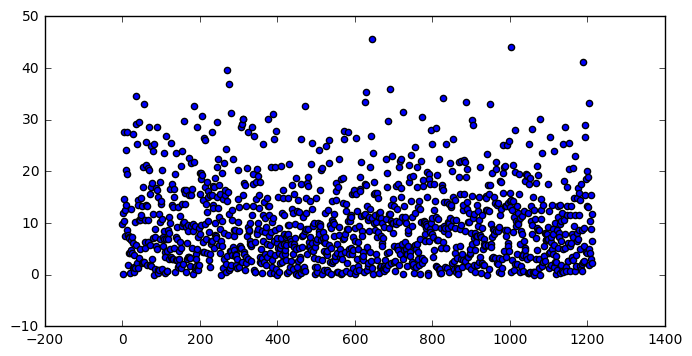

In [65]:
# graph errors over the course of season
deltas = []
for idx, pred in enumerate(lin_regr_predictions):
  actual_score_delta = labels_for_2016_2017[idx]
  deltas.append(abs(pred-actual_score_delta))
print len(deltas)
print len(range(0, len(labels_for_2016_2017)))
plt.figure(figsize=(8,4))
plt.scatter(range(0, len(labels_for_2016_2017)), deltas)

In [67]:
avg_0 = 0
for i in range(len(deltas)):
  avg_0 += deltas[i]
print "Average delta 0 games in: {}".format(avg_0/len(deltas))
avg_400 = 0
for i in range(400, len(deltas)):
  avg_400 += deltas[i]
print "Average delta 400 games in: {}".format(avg_400/(len(deltas)-400))
avg_800 = 0
for i in range(800, len(deltas)):
  avg_800 += deltas[i]
print "Average delta 800 games in: {}".format(avg_800/(len(deltas)-800))
avg_1000 = 0
for i in range(1000, len(deltas)):
  avg_1000 += deltas[i]
print "Average delta 1000 games in: {}".format(avg_1000/(len(deltas)-1000))

Average delta 0 games in: 10.1228914233
Average delta 400 games in: 9.75724572087
Average delta 800 games in: 9.90799584997
Average delta 1000 games in: 9.64480249956


In [68]:
avg_600_800 = 0
for i in range(600, 800):
  avg_600_800 += deltas[i]
print "Average delta between games 600 to 800: {}".format(avg_600_800/200)
avg_800_1000 = 0
for i in range(800, 1000):
  avg_800_1000 += deltas[i]
print "Average delta between games 800 to 1000: {}".format(avg_800_1000/200)
avg_1000_end = 0
for i in range(1000, len(deltas)):
  avg_1000_end += deltas[i]
print "Average delta between games 1000 to end: {}".format(avg_1000_end/(len(deltas) - 1000))

Average delta between games 600 to 800: 10.5075882047
Average delta between games 800 to 1000: 10.1896127349
Average delta between games 1000 to end: 9.64480249956


In [78]:
# Evaluate the classification case, do we at least predict the outcomes correctly?
correct_classifications = 0.
for idx, pred in enumerate(lin_regr_predictions):
  actual_score_delta = labels_for_2016_2017[idx]
  # if in the same direction
  if pred * actual_score_delta > 0:
    correct_classifications += 1
print "Classification rate: {}".format(correct_classifications/len(lin_regr_predictions))

Classification rate: 0.628500823723


In [25]:
regr_2016_2017.coef_

array([  6.25936511e+12,  -5.01708984e-01,  -3.83061523e+01,
         3.12968256e+12,   4.38720703e-01,   7.90063477e+00,
         3.12968256e+12,  -2.31933594e-02,   4.50463867e+00,
        -1.17490146e+12,  -1.17490146e+12,   1.17490146e+12,
         1.43615723e-01,   1.13769531e-01,   1.13571167e-01,
        -2.69592285e-01,  -5.84182739e-02,  -3.12968256e+12,
         5.22094727e-01,   3.59420509e+12,   1.10357666e+00,
         1.62182558e+02,   1.79710255e+12,   5.55419922e-02,
         1.47848396e+01,   1.79710255e+12,  -6.15600586e-01,
        -1.64176664e+01,  -9.91007675e+12,  -9.91007675e+12,
         9.91007675e+12,  -1.80541992e-01,  -1.84478760e-01,
        -2.45628357e-01,   3.21899414e-01,   2.50854492e-02,
        -1.79710255e+12,  -5.67138672e-01])

In [26]:
print "R^2: {}".format(regr_2016_2017.score(feature_vectors_for_2000_2016, labels_for_2000_2016))

R^2: 0.151549896917


In [47]:
# Train a multi-layer perceptron
from sklearn.neural_network import MLPRegressor

mlp_regr = MLPRegressor(hidden_layer_sizes=3, solver='lbfgs')
mlp_regr.fit(feature_vectors_for_2000_2016, labels_for_2000_2016)
mlp_regr_predictions = mlp_regr.predict(feature_vectors_for_2016_2017)

evaluate(0, mlp_regr_predictions)
print
evaluate(400, mlp_regr_predictions)
print
evaluate(800, mlp_regr_predictions)
print
evaluate(1000, mlp_regr_predictions)

0 games in
Win Percent: 0.511532125206
Loss Percent: 0.488467874794
Bets placed: 1214
Bets not placed: 0

400 games in
Win Percent: 0.530712530713
Loss Percent: 0.469287469287
Bets placed: 814
Bets not placed: 0

800 games in
Win Percent: 0.553140096618
Loss Percent: 0.446859903382
Bets placed: 414
Bets not placed: 0

1000 games in
Win Percent: 0.579439252336
Loss Percent: 0.420560747664
Bets placed: 214
Bets not placed: 0
